In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Load dataset
df = pd.read_csv("hourly_load.csv")  # replace with full path if needed
df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour

In [3]:
# Filter only June 2024
df_june = df[(df['datetime'].dt.year == 2024) & (df['datetime'].dt.month == 10)].copy()

# Define TOU price function (₹ per MWh)
def tou_price(hour):
    if 15 <= hour <= 23:
        return 10000   # Peak = ₹9/kWh = ₹9000/MWh
    elif 7 <= hour <= 14:
        return 4000   # Off-Peak = ₹4/kWh = ₹4000/MWh
    else:
        return 7000   # Mid-Peak = ₹6.5/kWh = ₹6500/MWh

# Classify tariff periods
def tou_period(hour):
    if 15 <= hour <= 23:
        return 'Peak'
    elif 7 <= hour <= 14:
        return 'Off-Peak'
    else:
        return 'Mid-Peak'


# Apply TOU structure
df_june['tou_period'] = df_june['hour'].apply(tou_period)
df_june['tou_price'] = df_june['hour'].apply(tou_price)


# Generation (smoothed forecast) and ramp penalty
#LAMBDA = 500  # ₹/MWh for deviation penalty
#df_june['generation'] = df_june['load'].rolling(window=24, min_periods=1).mean()
df_june['ramp'] = df_june['load'].diff().fillna(0).abs()

# Flat pricing (₹/MWh)
FLAT_PRICE = 7000  # ₹7/kWh = ₹7000/MWh

# Calculate costs (Load in MW = MWh per hour)
df_june['flat_cost'] = FLAT_PRICE * df_june['load'] #+ LAMBDA * abs(df_june['generation'] - df_june['load'])
df_june['tou_cost'] = df_june['tou_price'] * df_june['load'] #+ LAMBDA * abs(df_june['generation'] - df_june['load'])

# Summary
flat_total = df_june['flat_cost'].sum()
tou_total = df_june['tou_cost'].sum()
savings = flat_total - tou_total

In [4]:
# Apply TOU structure
df_june['tou_period'] = df_june['hour'].apply(tou_period)
df_june['tou_price'] = df_june['hour'].apply(tou_price)


# Generation (smoothed forecast) and ramp penalty
#LAMBDA = 500  # ₹/MWh for deviation penalty
df_june['generation'] = df_june['load'].rolling(window=24, min_periods=1).mean()
df_june['ramp'] = df_june['load'].diff().fillna(0).abs()

# Flat pricing (₹/MWh)
FLAT_PRICE = 7000  # ₹7/kWh = ₹7000/MWh

# Calculate costs (Load in MW = MWh per hour)
df_june['flat_cost'] = FLAT_PRICE * df_june['load'] #+ LAMBDA * abs(df_june['generation'] - df_june['load'])
df_june['tou_cost'] = df_june['tou_price'] * df_june['load'] #+ LAMBDA * abs(df_june['generation'] - df_june['load'])

# Summary
flat_total = df_june['flat_cost'].sum()
tou_total = df_june['tou_cost'].sum()
savings = flat_total - tou_total

In [5]:
summary = f"""
✅ TOU Tariff Optimization Summary for October 2024
Total cost with flat pricing (₹{FLAT_PRICE}/MWh): ₹{flat_total:,.2f}
Total cost with TOU pricing: ₹{tou_total:,.2f}
✅ Total savings for October 2024: ₹{savings:,.2f}
"""
print(summary)


✅ TOU Tariff Optimization Summary for October 2024
Total cost with flat pricing (₹7000/MWh): ₹249,416,573,700.00
Total cost with TOU pricing: ₹247,247,719,500.00
✅ Total savings for October 2024: ₹2,168,854,200.00



<ipython-input-6-a7d85d7240e2>:8: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(x, y_flat, '-', label='Flat Pricing Cost (₹7000/MWh)', alpha=0.7)
<ipython-input-6-a7d85d7240e2>:9: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(x, y_tou, '-', label='TOU Optimized Cost', linewidth=1)


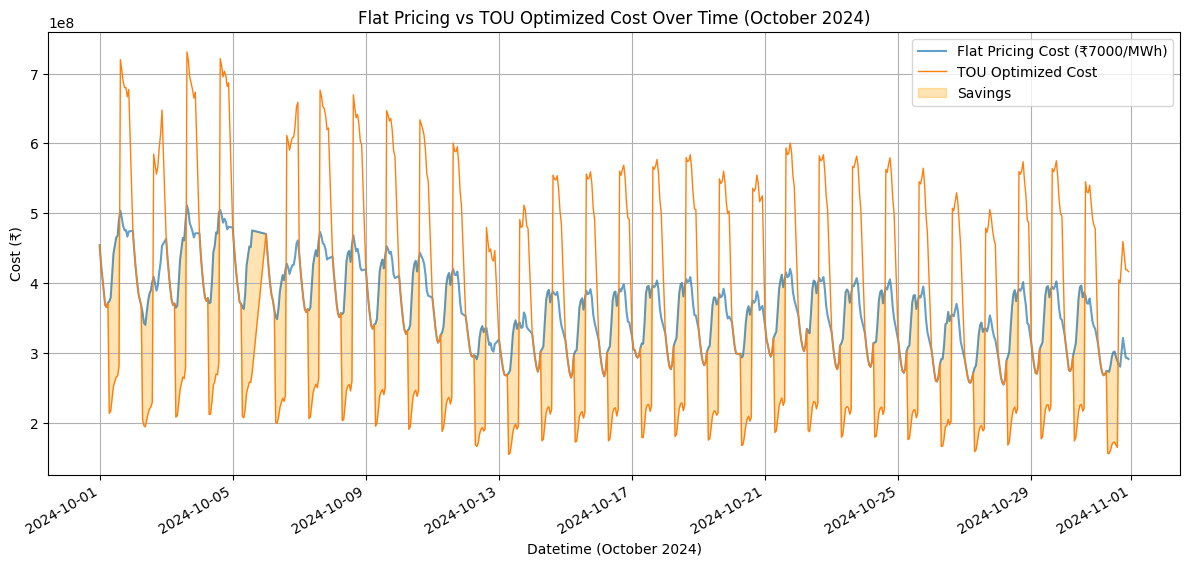

In [6]:
# Plotting
x = mdates.date2num(df_june['datetime'].values)
y_flat = df_june['flat_cost'].values.astype(float)
y_tou = df_june['tou_cost'].values.astype(float)
mask = y_flat > y_tou

plt.figure(figsize=(12, 6))
plt.plot_date(x, y_flat, '-', label='Flat Pricing Cost (₹7000/MWh)', alpha=0.7)
plt.plot_date(x, y_tou, '-', label='TOU Optimized Cost', linewidth=1)
plt.fill_between(x, y_tou, y_flat, where=mask, interpolate=True,
                 color='orange', alpha=0.3, label='Savings')
plt.xlabel("Datetime (October 2024)")
plt.ylabel("Cost (₹)")
plt.title("Flat Pricing vs TOU Optimized Cost Over Time (October 2024)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

In [7]:
df_june.head()

,datetime,load,hour,tou_period,tou_price,ramp,flat_cost,tou_cost,generation
56622,2024-10-01 00:00:00,64903.92,0,Mid-Peak,7000,0.00,454327440.0,454327440.0,64903.920000
56623,2024-10-01 01:00:00,61186.34,1,Mid-Peak,7000,3717.58,428304380.0,428304380.0,63045.130000
56624,2024-10-01 02:00:00,58330.85,2,Mid-Peak,7000,2855.49,408315950.0,408315950.0,61473.703333
56625,2024-10-01 03:00:00,55353.01,3,Mid-Peak,7000,2977.84,387471070.0,387471070.0,59943.530000
56626,2024-10-01 04:00:00,52691.84,4,Mid-Peak,7000,2661.17,368842880.0,368842880.0,58493.192000
